# **Detecting Misinformation**

### Import Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer 
import scipy.sparse as sp 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump
from sklearn.metrics import confusion_matrix
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import joblib
import re
import string


### Loading The Datasets

In [7]:
# Loading the true_news dataset

true_news = pd.read_csv('True.csv')
true_news.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
# Loading the fake_news dataset

fake_news = pd.read_csv('Fake.csv')
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
# Printing the shape of each DataFrame

print("Shape of true_news dataset:", true_news.shape)
print("Shape of fake_news dataset:", fake_news.shape)

Shape of true_news dataset: (21417, 4)
Shape of fake_news dataset: (23481, 4)


In [13]:
# Printing the info of each DataFrame

print("Info of true_news dataset:")
print(true_news.info())

print("\nInfo of fake_news dataset:")
print(fake_news.info())

Info of true_news dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None

Info of fake_news dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


In [15]:
# Checking the column names of true_news dataset
print("Column names of true_news dataset:")
print(list(true_news.columns))

# Checking the column names of fake_news dataset
print("\nColumn names of fake_news dataset:")
print(list(fake_news.columns))

Column names of true_news dataset:
['title', 'text', 'subject', 'date']

Column names of fake_news dataset:
['title', 'text', 'subject', 'date']


In [17]:
#checking for duplicates in fake news dataset
fake_news.duplicated().sum()

3

In [19]:
#checking for duplicates in true news dataset
true_news.duplicated().sum()

206

In [21]:
# Identify duplicates
duplicates = fake_news[fake_news.duplicated()]

# Display duplicates
print("Fake News Duplicate Rows:")
duplicates.head()

Fake News Duplicate Rows:


,title,text,subject,date
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


In [23]:
# Identify duplicates
duplicates = true_news[true_news.duplicated()]

# Display duplicates
print("True News Duplicate Rows:")
duplicates.head()

True News Duplicate Rows:


,title,text,subject,date
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"November 2, 2017"
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,"October 30, 2017"


In [25]:
# Drop duplicates and update the DataFrame in place
true_news.drop_duplicates(inplace=True)

# Check the shape of the DataFrame after dropping duplicates
true_news.shape


(21211, 4)

In [27]:
# Drop duplicates and update the DataFrame in place
fake_news.drop_duplicates(inplace=True)

# Check the shape of the DataFrame after dropping duplicates
fake_news.shape


(23478, 4)

In [29]:
first_row_text = fake_news.loc[0, 'text']  # Accessing text of the first row
word_count = len(first_row_text.split())  # Counting words by splitting on whitespace

print("Word count of the first row in the fake news dataset:", word_count)

Word count of the first row in the fake news dataset: 495


In [31]:
first_row_text = true_news.loc[0, 'text']  # Accessing text of the first row
word_count = len(first_row_text.split())  # Counting words by splitting on whitespace

print("Word count of the first row in the true news dataset:", word_count)

Word count of the first row in the true news dataset: 749


### Checking the sum of missing values 

In [34]:
true_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [36]:
fake_news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

#### Assigning Classes to the Dataset

In [39]:
true_news['class'] = 'True'
fake_news['class'] = 'Fake'

combined_data = pd.concat([true_news, fake_news])

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply label encoding to convert 'class' into numeric labels
combined_data['class'] = label_encoder.fit_transform(combined_data['class'])


# Display a sample to check the result
combined_data.head()


,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [41]:
# Printing value counts for the 'subject' column in the true_news dataset
print("true_news dataset:")
print(true_news['subject'].value_counts())

# Printing value counts for the 'subject' column in the fake_news dataset
print("\nfake_news dataset:")
print(fake_news['subject'].value_counts())

true_news dataset:
subject
politicsNews    11220
worldnews        9991
Name: count, dtype: int64

fake_news dataset:
subject
News               9050
politics           6838
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64


## 3. Exploratory Data Analysis

### Distribution of Subject Column

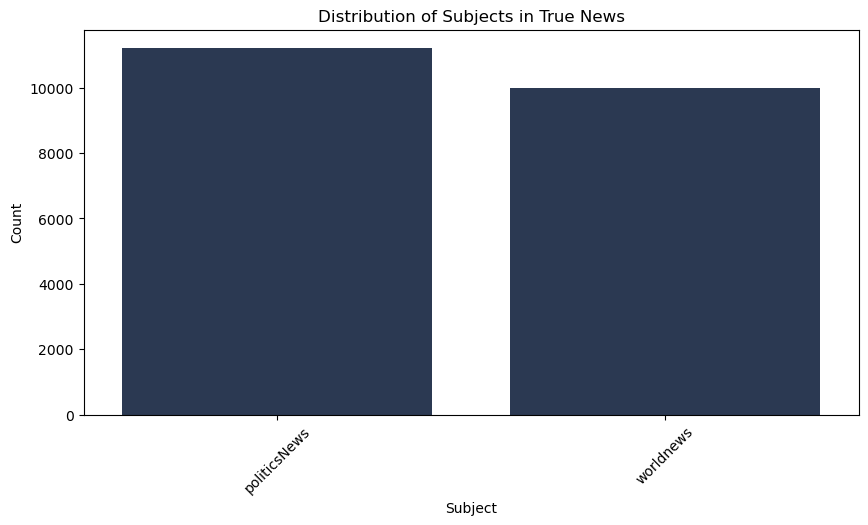

In [45]:
# Get the distribution of 'subject' in both datasets
true_subject_counts = true_news['subject'].value_counts()
fake_subject_counts = fake_news['subject'].value_counts()


# Plot the distribution for true news
plt.figure(figsize=(10, 5))
sns.barplot(x=true_subject_counts.index, y=true_subject_counts.values, color = '#253758')
plt.title('Distribution of Subjects in True News')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()



It shows the distribution of subjects in true news. The higher the count, the more news articles were about that subject.


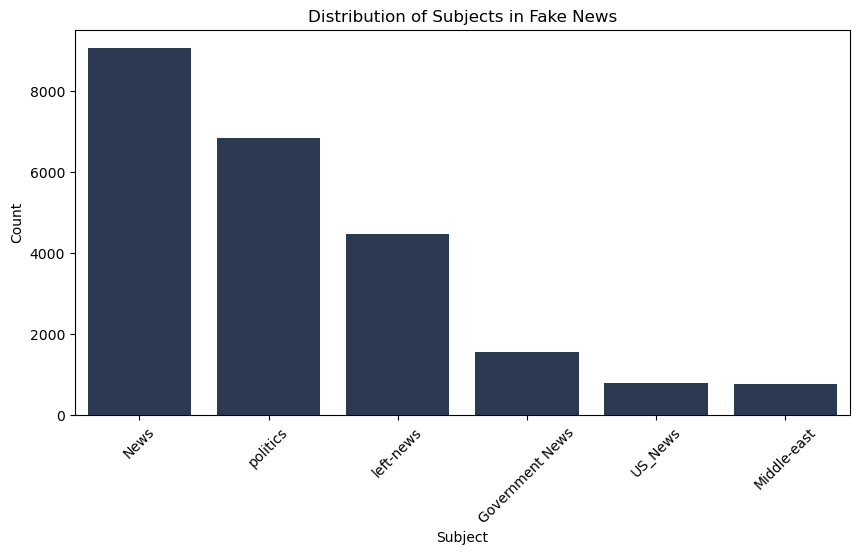

In [48]:
# Plot the distribution for fake news
plt.figure(figsize=(10, 5))
sns.barplot(x=fake_subject_counts.index, y=fake_subject_counts.values, color ='#253758')
plt.title('Distribution of Subjects in Fake News')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


It shows the distribution of subjects in fake news by content. The content is divided into a number of different categories, including news, politics, and government. The most common subjects in fake news are news, politics, and government.

### Analysis of Article Length (Word Count)


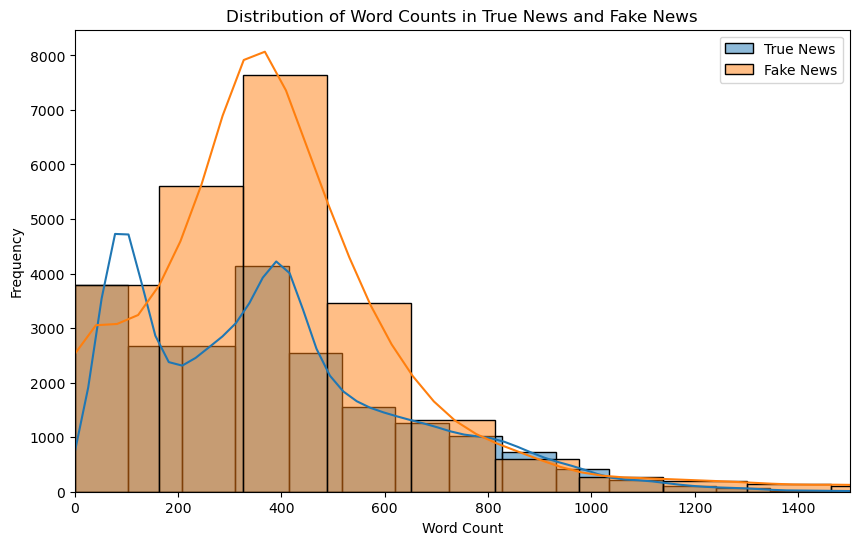

In [52]:

# Calculate word counts for both datasets
true_news['word_count'] = true_news['text'].apply(lambda x: len(x.split()))
fake_news['word_count'] = fake_news['text'].apply(lambda x: len(x.split()))

# Create a single plot with histograms for both datasets
plt.figure(figsize=(10, 6))
sns.histplot(true_news, x='word_count', kde='True', alpha=0.5, label='True News', bins=50)
sns.histplot(data=fake_news, x='word_count', kde='True', alpha=0.5, label='Fake News', bins=50)
plt.title('Distribution of Word Counts in True News and Fake News' )
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 1500)
plt.legend()
plt.show()


- This  aims to visually compare the distribution of word counts between true and fake news datasets.

### Investigate Relationships between Subject and Class

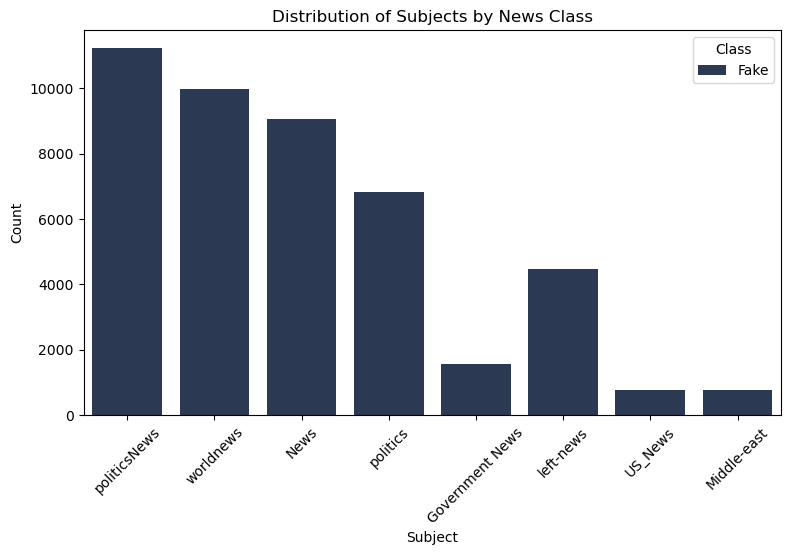

In [56]:

# Plot the relationship between 'subject' and 'class' using count plot
plt.figure(figsize=(9, 5))
sns.countplot(data=combined_data, x='subject', color='#253758')
plt.title("Distribution of Subjects by News Class")
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Fake', 'True'])
plt.show()


There were more news stories about politics than any other subject. Politics news stories are broken down further into subcategories, such as Government News, World News, and US News.

###  Checking for Class Imbalance

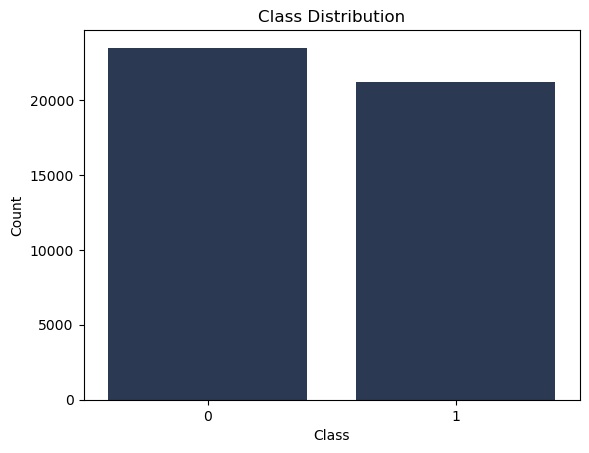

In [60]:
# Check the count of each class
class_distribution = combined_data['class'].value_counts()

# Plot the distribution to visualize any imbalance
sns.countplot(combined_data, x='class', color='#253758')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

- The distribution between the two classes  is approximately even.

## 4. Text Preprocessing

Text processing helps to prepare the text data for further analysis or modeling by cleaning it and reducing each word to its base form through stemming or lemmatization.

In [65]:
# Setup for stopwords, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def remove_punctuation(text):   
    text = unicodedata.normalize('NFKD', text)
    extra_punctuation = '“”‘’—–' 
    punctuation = string.punctuation + extra_punctuation
    translator = str.maketrans('', '', punctuation)
    return text.translate(translator)

def preprocess_text(text):
    text = text.lower()
    text = remove_punctuation(text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

In [67]:
# Apply the preprocess_text function to your DataFrame columns
true_news['text'] = true_news['text'].apply(preprocess_text)
fake_news['text'] = fake_news['text'].apply(preprocess_text)

In [68]:
# Tokenize and remove stop words for true news
true_tokens = [word for text in true_news['text'] for word in text.split() if word not in stop_words]

# Tokenize and remove stop words for fake news
fake_tokens = [word for text in fake_news['text'] for word in text.split() if word not in stop_words]

### Visualization: Word Clouds

Text(0.5, 1.0, 'Word Cloud for True News')

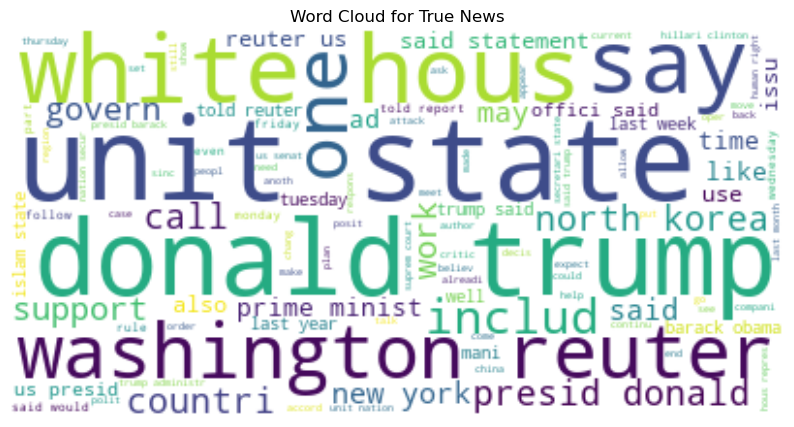

In [72]:
# Create a word cloud for true news
wordcloud_true = WordCloud(stopwords=stop_words, background_color='white').generate(' '.join(true_tokens))

# Create a word cloud for fake news
wordcloud_fake = WordCloud(stopwords=stop_words, background_color='white').generate(' '.join(fake_tokens))

# Plot word clouds
plt.figure(figsize=(10, 12))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News')

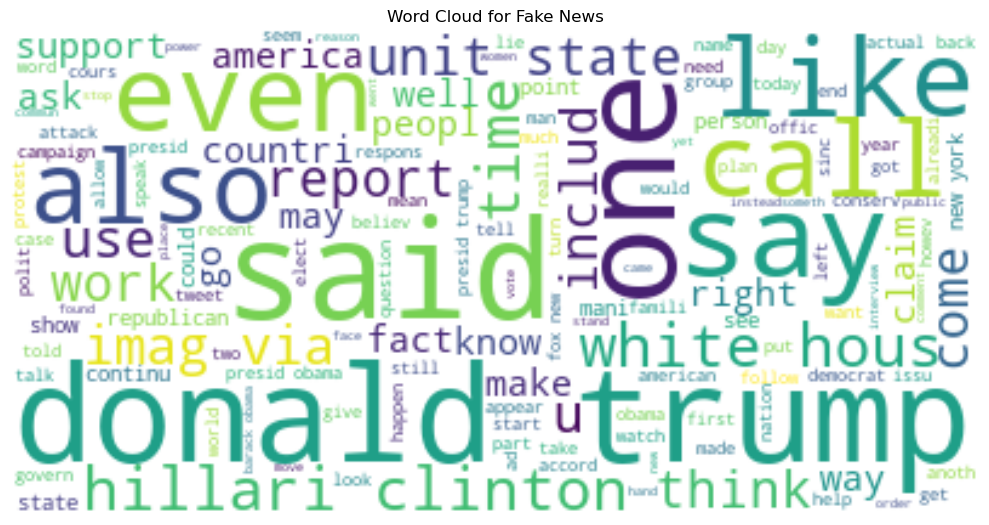

In [74]:
plt.figure(figsize=(10, 12))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')

plt.tight_layout()
plt.show()

#### Most Common Words in True News And Fake News

In [77]:
# Create word frequency counters
true_word_count = Counter(true_tokens)
fake_word_count = Counter(fake_tokens)

# Most common words in each dataset
most_common_true = true_word_count.most_common(10)
most_common_fake = fake_word_count.most_common(10)

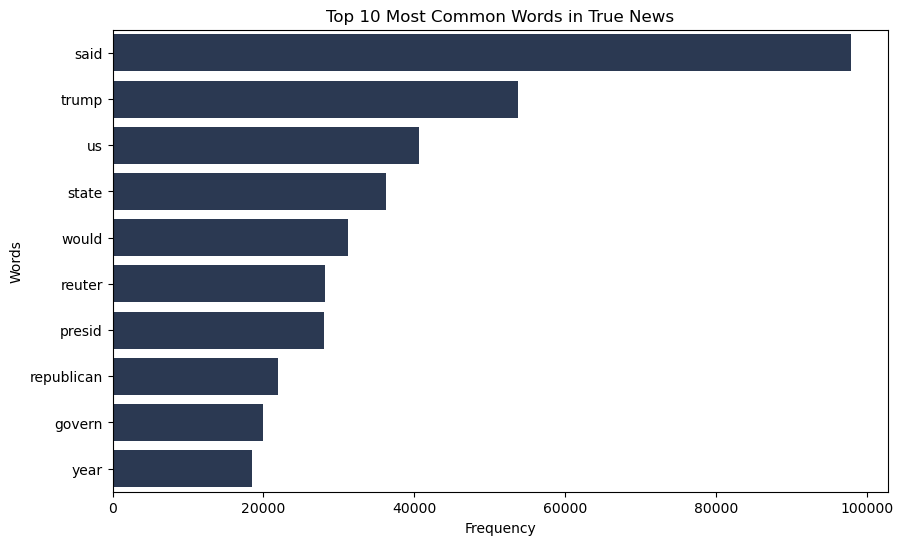

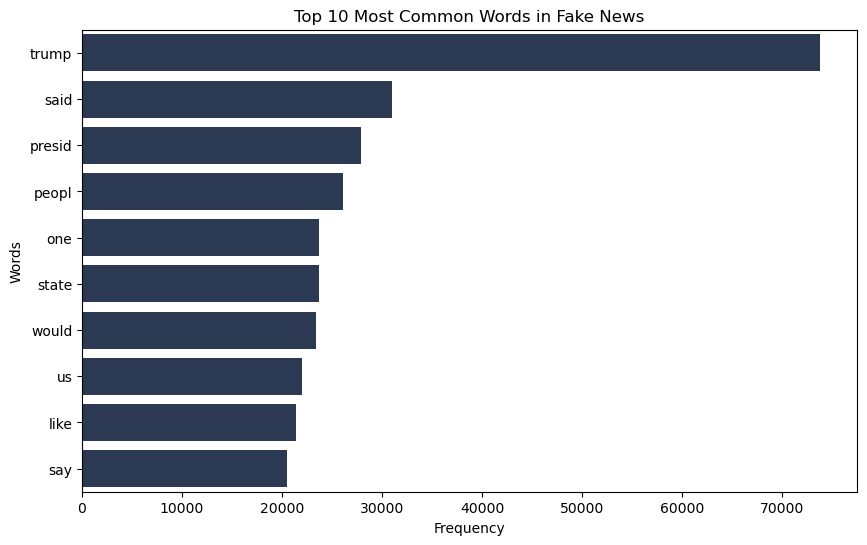

In [78]:
# Create bar plots for the most common words in true news
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[1] for x in most_common_true[:10]], y=[x[0] for x in most_common_true[:10]], color='#253758')
plt.title('Top 10 Most Common Words in True News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Create bar plots for the most common words in fake news
plt.figure(figsize=(10, 6))
sns.barplot(x=[x[1] for x in most_common_fake[:10]], y=[x[0] for x in most_common_fake[:10]], color='#253758')
plt.title('Top 10 Most Common Words in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()



- This indicates some of the most common words in both datasets are related to politics and Donald Trump. 

## 5. Modeling
### Model Training

In [83]:
vectorizer = CountVectorizer()
X_real = vectorizer.fit_transform(true_news['text'])
X_fake = vectorizer.transform(fake_news['text'])
X = sp.vstack([X_real, X_fake])
y = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_fake.shape[0])])   

In [85]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1. Logistic Regression

In [88]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [90]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.9953009621839337


- These metrics suggest that the baseline model (logistic regression model) is performing exceptionally well in identifying fake news. 

#### 2. Naive Bayes

In [95]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf_nb = MultinomialNB()

# Train the model on the training data
clf_nb.fit(X_train, y_train)


MultinomialNB()

In [97]:
# Make predictions on the test set
y_pred_nb = clf_nb.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print('Naive Bayes Accuracy:', accuracy_nb)

Naive Bayes Accuracy: 0.947751174759454


#### 3. Support Vector Machine(SVM)

In [100]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instantiate the SVM classifier
clf_svm = SVC(kernel='linear', random_state=42)  # Using a linear kernel for text classification

# Train the model on the training data
clf_svm.fit(X_train, y_train)



SVC(kernel='linear', random_state=42)

In [102]:
# Make predictions on the test set
y_pred_svm = clf_svm.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', accuracy_svm)

SVM Accuracy: 0.9950771984784068


## Model Evaluation


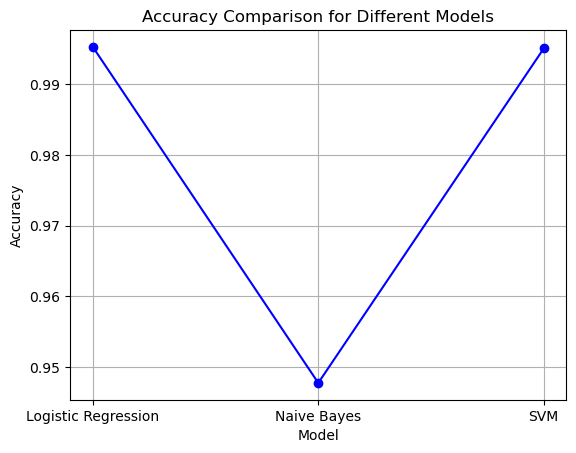

In [108]:
model_names = ['Logistic Regression', 'Naive Bayes', 'SVM']
accuracies = [0.9953, 0.947751, 0.995077] 

# Create a line plot
plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Models')
plt.grid(True)
plt.show()


- Logistic Regression:
Accuracy: 99.53% (highest among the three models).
- Naive Bayes:
Accuracy: 94.77% (highest among the three models).
- SVM:
Accuracy: 99.50% (highest among the three models).


- Logistic Regression and SVM performed the best in terms of accuracy.

In [112]:
from sklearn.metrics import classification_report

# Generate and print classification reports
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred))

print("\nNaive Bayes Report:")
print(classification_report(y_test, y_pred_nb))

print("\nSVM Report:")
print(classification_report(y_test, y_pred_svm))


Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4648
         1.0       1.00      0.99      1.00      4290

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938


Naive Bayes Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      4648
         1.0       0.95      0.94      0.95      4290

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938


SVM Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      4648
         1.0       1.00      0.99      0.99      4290

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg

# Limitations

While the project has made significant strides in fake news detection, several limitations must be acknowledged. Firstly, the dataset used for training and evaluation primarily consists of news articles from the United States, predominantly focusing on political subjects. This inherent bias in the data may limit the generalizability of the models to other regions or topics. Moreover, the dataset size, while substantial, may not encompass the full spectrum of fake news characteristics, potentially leading to model overfitting or underperformance on unseen data. Additionally, the preprocessing techniques applied to the text data, such as stemming or lemmatization, may inadvertently remove context or nuance crucial for accurate classification. 